In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from loguru import logger

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.sparse as sparse
import torch.optim as optim

import pandas as pd
import plotly.express as px

sys.path.insert(0, '..')

from src.viz import blueq_colors

# Implement

In [3]:
from src.train_utils import mse_loss, train, MetricLogCallback
from src.model import LightGCN

In [4]:
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
device = 'cpu'
logger.info(f"Using {device} device")

2024-09-08 16:27:34.444 | INFO     | __main__:<module>:9 - Using cpu device


# Test implementation

In [5]:
# Mock data
user_ids = [0, 0, 1, 2, 2]
item_ids = [0, 1, 2, 3, 1]
interaction_scores = [1, 4, 5, 3, 2]
n_users = len(set(user_ids))
n_items = len(set(item_ids))

val_user_ids = [0, 1, 2]
val_item_ids = [2, 1, 2]
val_interaction_scores = [2, 4, 5]

model = LightGCN(embedding_dim=64, n_layers=3, user_ids=user_ids, item_ids=item_ids, interaction_scores=interaction_scores, device=device)

# Example forward pass
users = torch.tensor([0, 1, 2])
items = torch.tensor([0, 1, 2])
predictions = model.predict(users, items)
print(predictions)

tensor([-0.0045, -0.0028,  0.0095], grad_fn=<SumBackward1>)


In [6]:
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Fixing random seed for reproducibility
random.seed(42)
np.random.seed(42)

embedding_dim = 8
n_layers = 3
batch_size = 4

# Display mock dataset
print("Mock User IDs:", user_ids)
print("Mock Item IDs:", item_ids)
print("Interaction Scores:", interaction_scores)

class RatingDataset(Dataset):
    def __init__(self, user_ids, item_ids, ratings):
        """
        Args:
            user_ids (list or array): List of user indices.
            item_ids (list or array): List of item indices.
            ratings (list or array): List of corresponding ratings.
        """
        self.user_ids = user_ids
        self.item_ids = item_ids
        self.ratings = ratings
    
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, idx):
        user = self.user_ids[idx]
        item = self.item_ids[idx]
        rating = self.ratings[idx]
        return user, item, rating

rating_dataset = RatingDataset(user_ids, item_ids, interaction_scores)
dataloader = DataLoader(rating_dataset, batch_size=batch_size, shuffle=True)

val_rating_dataset = RatingDataset(val_user_ids, val_item_ids, val_interaction_scores)
val_dataloader = DataLoader(val_rating_dataset, batch_size=batch_size, shuffle=True)

# Instantiate LightGCN model
model = LightGCN(embedding_dim=embedding_dim, n_layers=n_layers,
                 user_ids=user_ids, item_ids=item_ids, interaction_scores=interaction_scores, device=device)

# Training loop
n_epochs = 50

train(model, dataloader, val_dataloader, epochs=n_epochs, patience=2, print_steps=1, lr=0.001, device=device, progress_bar_type='tqdm_notebook')

Mock User IDs: [0, 0, 1, 2, 2]
Mock Item IDs: [0, 1, 2, 3, 1]
Interaction Scores: [1, 4, 5, 3, 2]


/home/dvquys/frostmourne/reco-algo/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s]

2024-09-08 16:27:34.997 | INFO     | src.train_utils:train:124 - Step 1, Global Loss: 13.4989
2024-09-08 16:27:34.997 | INFO     | src.train_utils:train:127 - Step 1, Learning Rate: 0.001000
2024-09-08 16:27:34.998 | INFO     | src.train_utils:train:130 - Step 1, Gradient Norms: {'grad_norm_user_embedding.weight': 0.06086835637688637, 'grad_norm_item_embedding.weight': 0.06571412831544876, 'total_grad_norm': 0.0895728947186754}
2024-09-08 16:27:35.000 | INFO     | src.train_utils:train:124 - Step 2, Global Loss: 7.2499
2024-09-08 16:27:35.000 | INFO     | src.train_utils:train:127 - Step 2, Learning Rate: 0.001000
2024-09-08 16:27:35.001 | INFO     | src.train_utils:train:130 - Step 2, Gradient Norms: {'grad_norm_user_embedding.weight': 0.03868763893842697, 'grad_norm_item_embedding.weight': 0.01864035241305828, 'total_grad_norm': 0.04294410488894952}
2024-09-08 16:27:35.001 | INFO     | src.train_utils:train:142 - Epoch 1, Loss: 7.2499
2024-09-08 16:27:35.002 | INFO     | src.train_ut

Training Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s]

2024-09-08 16:27:35.008 | INFO     | src.train_utils:train:124 - Step 3, Global Loss: 9.7477
2024-09-08 16:27:35.008 | INFO     | src.train_utils:train:127 - Step 3, Learning Rate: 0.001000
2024-09-08 16:27:35.008 | INFO     | src.train_utils:train:130 - Step 3, Gradient Norms: {'grad_norm_user_embedding.weight': 0.05573795735836029, 'grad_norm_item_embedding.weight': 0.06286942958831787, 'total_grad_norm': 0.08401955169627394}
2024-09-08 16:27:35.009 | INFO     | src.train_utils:train:124 - Step 4, Global Loss: 12.8749
2024-09-08 16:27:35.010 | INFO     | src.train_utils:train:127 - Step 4, Learning Rate: 0.001000
2024-09-08 16:27:35.010 | INFO     | src.train_utils:train:130 - Step 4, Gradient Norms: {'grad_norm_user_embedding.weight': 0.10878351330757141, 'grad_norm_item_embedding.weight': 0.07383516430854797, 'total_grad_norm': 0.13147427222087538}
2024-09-08 16:27:35.011 | INFO     | src.train_utils:train:142 - Epoch 2, Loss: 12.8749
2024-09-08 16:27:35.011 | INFO     | src.train_

Training Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s]

2024-09-08 16:27:35.016 | INFO     | src.train_utils:train:124 - Step 5, Global Loss: 12.7503
2024-09-08 16:27:35.016 | INFO     | src.train_utils:train:127 - Step 5, Learning Rate: 0.001000
2024-09-08 16:27:35.016 | INFO     | src.train_utils:train:130 - Step 5, Gradient Norms: {'grad_norm_user_embedding.weight': 0.057800907641649246, 'grad_norm_item_embedding.weight': 0.06154323369264603, 'total_grad_norm': 0.08443053083776098}
2024-09-08 16:27:35.017 | INFO     | src.train_utils:train:124 - Step 6, Global Loss: 8.3696
2024-09-08 16:27:35.017 | INFO     | src.train_utils:train:127 - Step 6, Learning Rate: 0.001000
2024-09-08 16:27:35.018 | INFO     | src.train_utils:train:130 - Step 6, Gradient Norms: {'grad_norm_user_embedding.weight': 0.054469067603349686, 'grad_norm_item_embedding.weight': 0.09131339192390442, 'total_grad_norm': 0.10632504347625188}
2024-09-08 16:27:35.018 | INFO     | src.train_utils:train:142 - Epoch 3, Loss: 8.3696
2024-09-08 16:27:35.019 | INFO     | src.train

# Prep data

In [7]:
train_df = pd.read_parquet("../data/train.parquet")
val_df = pd.read_parquet("../data/val.parquet")

In [8]:
from src.id_mapper import IDMapper

In [9]:
user_ids = train_df['user_id'].values
item_ids = train_df['parent_asin'].values
unique_user_ids = list(set(user_ids))
unique_item_ids = list(set(item_ids))

logger.info(f"{len(unique_user_ids)=:,.0f}, {len(unique_item_ids)=:,.0f}")

2024-09-08 16:27:35.100 | INFO     | __main__:<module>:6 - len(unique_user_ids)=5,223, len(unique_item_ids)=2,653


In [10]:
idm = IDMapper()
idm.fit(unique_user_ids, unique_item_ids)

In [11]:
user_indices = [idm.get_user_index(user_id) for user_id in user_ids]
item_indices = [idm.get_item_index(item_id) for item_id in item_ids]
ratings = train_df['rating'].values.tolist()

In [12]:
val_user_indices = [idm.get_user_index(user_id) for user_id in val_df['user_id']]
val_item_indices = [idm.get_item_index(item_id) for item_id in val_df['parent_asin']]
val_ratings = val_df['rating'].values.tolist()

# Train

In [13]:
rating_dataset = RatingDataset(user_indices, item_indices, ratings)
dataloader = DataLoader(rating_dataset, batch_size=batch_size, shuffle=True)

val_rating_dataset = RatingDataset(val_user_indices, val_item_indices, val_ratings)
val_dataloader = DataLoader(val_rating_dataset, batch_size=batch_size, shuffle=True)

In [14]:
embedding_dim = 128
n_layers = 3
batch_size = 256

# Instantiate LightGCN model
model = LightGCN(embedding_dim=embedding_dim, n_layers=n_layers,
                 user_ids=user_indices, item_ids=item_indices, interaction_scores=ratings, device=device)

#### Predict before train

In [15]:
user_id = 'AEHW2B54HDLZ3APBEWXHYLZ6SSYQ'
val_df.loc[lambda df: df['user_id'].eq(user_id)]

,user_id,parent_asin,rating,timestamp
34367,AEHW2B54HDLZ3APBEWXHYLZ6SSYQ,B07MYVF61Y,4.0,1654225907045


In [16]:
item_id = 'B07MYVF61Y'
user_indice = idm.get_user_index(user_id)
item_indice = idm.get_item_index(item_id)

model.predict([user_indice], [item_indice])

tensor([0.0057], grad_fn=<SumBackward1>)

#### Training loop

In [17]:
n_epochs = 50

metric_log_cb = MetricLogCallback()

train(
    model,
    dataloader,
    val_dataloader,
    epochs=n_epochs,
    patience=2,
    print_steps=100,
    lr=0.03,
    device=device,
    progress_bar_type='tqdm_notebook',
    callbacks=[metric_log_cb.process_payload]
)

/home/dvquys/frostmourne/reco-algo/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/4524 [00:00<?, ?it/s]

2024-09-08 16:27:37.220 | INFO     | src.train_utils:train:124 - Step 100, Global Loss: 19.6030
2024-09-08 16:27:37.220 | INFO     | src.train_utils:train:127 - Step 100, Learning Rate: 0.030000
2024-09-08 16:27:37.220 | INFO     | src.train_utils:train:130 - Step 100, Gradient Norms: {'grad_norm_user_embedding.weight': 0.06473526358604431, 'grad_norm_item_embedding.weight': 0.0008847127319313586, 'total_grad_norm': 0.06474130882344499}
2024-09-08 16:27:39.134 | INFO     | src.train_utils:train:124 - Step 200, Global Loss: 19.5010
2024-09-08 16:27:39.134 | INFO     | src.train_utils:train:127 - Step 200, Learning Rate: 0.030000
2024-09-08 16:27:39.135 | INFO     | src.train_utils:train:130 - Step 200, Gradient Norms: {'grad_norm_user_embedding.weight': 0.2813809812068939, 'grad_norm_item_embedding.weight': 0.7527627348899841, 'total_grad_norm': 0.8036336177786509}
2024-09-08 16:27:41.154 | INFO     | src.train_utils:train:124 - Step 300, Global Loss: 19.4848
2024-09-08 16:27:41.155 | I

Training Epoch 2:   0%|          | 0/4524 [00:00<?, ?it/s]

2024-09-08 16:29:19.973 | INFO     | src.train_utils:train:124 - Step 4600, Global Loss: 6.6280
2024-09-08 16:29:19.974 | INFO     | src.train_utils:train:127 - Step 4600, Learning Rate: 0.019683
2024-09-08 16:29:19.974 | INFO     | src.train_utils:train:130 - Step 4600, Gradient Norms: {'grad_norm_user_embedding.weight': 0.7003979682922363, 'grad_norm_item_embedding.weight': 0.7137516736984253, 'total_grad_norm': 0.9999993828474075}
2024-09-08 16:29:22.059 | INFO     | src.train_utils:train:124 - Step 4700, Global Loss: 6.0721
2024-09-08 16:29:22.059 | INFO     | src.train_utils:train:127 - Step 4700, Learning Rate: 0.019683
2024-09-08 16:29:22.060 | INFO     | src.train_utils:train:130 - Step 4700, Gradient Norms: {'grad_norm_user_embedding.weight': 0.8735626339912415, 'grad_norm_item_embedding.weight': 0.48671087622642517, 'total_grad_norm': 0.9999995762713153}
2024-09-08 16:29:24.220 | INFO     | src.train_utils:train:124 - Step 4800, Global Loss: 6.0869
2024-09-08 16:29:24.221 | I

Training Epoch 3:   0%|          | 0/4524 [00:00<?, ?it/s]

2024-09-08 16:31:03.284 | INFO     | src.train_utils:train:124 - Step 9100, Global Loss: 2.8983
2024-09-08 16:31:03.284 | INFO     | src.train_utils:train:127 - Step 9100, Learning Rate: 0.011623
2024-09-08 16:31:03.284 | INFO     | src.train_utils:train:130 - Step 9100, Gradient Norms: {'grad_norm_user_embedding.weight': 0.8506601452827454, 'grad_norm_item_embedding.weight': 0.5257142186164856, 'total_grad_norm': 0.9999990612135611}
2024-09-08 16:31:05.383 | INFO     | src.train_utils:train:124 - Step 9200, Global Loss: 3.3231
2024-09-08 16:31:05.384 | INFO     | src.train_utils:train:127 - Step 9200, Learning Rate: 0.011623
2024-09-08 16:31:05.384 | INFO     | src.train_utils:train:130 - Step 9200, Gradient Norms: {'grad_norm_user_embedding.weight': 0.7824446558952332, 'grad_norm_item_embedding.weight': 0.572475254535675, 'total_grad_norm': 0.9695089254848022}
2024-09-08 16:31:07.554 | INFO     | src.train_utils:train:124 - Step 9300, Global Loss: 3.4198
2024-09-08 16:31:07.554 | INF

Training Epoch 4:   0%|          | 0/4524 [00:00<?, ?it/s]

2024-09-08 16:32:50.139 | INFO     | src.train_utils:train:124 - Step 13600, Global Loss: 2.4200
2024-09-08 16:32:50.139 | INFO     | src.train_utils:train:127 - Step 13600, Learning Rate: 0.007626
2024-09-08 16:32:50.140 | INFO     | src.train_utils:train:130 - Step 13600, Gradient Norms: {'grad_norm_user_embedding.weight': 0.7173436880111694, 'grad_norm_item_embedding.weight': 0.6967180371284485, 'total_grad_norm': 0.999998994994287}
2024-09-08 16:32:52.372 | INFO     | src.train_utils:train:124 - Step 13700, Global Loss: 2.1328
2024-09-08 16:32:52.373 | INFO     | src.train_utils:train:127 - Step 13700, Learning Rate: 0.007626
2024-09-08 16:32:52.373 | INFO     | src.train_utils:train:130 - Step 13700, Gradient Norms: {'grad_norm_user_embedding.weight': 0.8249505758285522, 'grad_norm_item_embedding.weight': 0.4962416887283325, 'total_grad_norm': 0.9627041426065472}
2024-09-08 16:32:54.639 | INFO     | src.train_utils:train:124 - Step 13800, Global Loss: 2.1827
2024-09-08 16:32:54.64

Training Epoch 5:   0%|          | 0/4524 [00:00<?, ?it/s]

2024-09-08 16:34:41.116 | INFO     | src.train_utils:train:124 - Step 18100, Global Loss: 1.7083
2024-09-08 16:34:41.117 | INFO     | src.train_utils:train:127 - Step 18100, Learning Rate: 0.004503
2024-09-08 16:34:41.117 | INFO     | src.train_utils:train:130 - Step 18100, Gradient Norms: {'grad_norm_user_embedding.weight': 0.3606943190097809, 'grad_norm_item_embedding.weight': 0.6916718482971191, 'total_grad_norm': 0.7800707259554627}
2024-09-08 16:34:43.343 | INFO     | src.train_utils:train:124 - Step 18200, Global Loss: 1.8452
2024-09-08 16:34:43.343 | INFO     | src.train_utils:train:127 - Step 18200, Learning Rate: 0.004503
2024-09-08 16:34:43.344 | INFO     | src.train_utils:train:130 - Step 18200, Gradient Norms: {'grad_norm_user_embedding.weight': 0.35776984691619873, 'grad_norm_item_embedding.weight': 0.3625970482826233, 'total_grad_norm': 0.5093877528815464}
2024-09-08 16:34:45.581 | INFO     | src.train_utils:train:124 - Step 18300, Global Loss: 1.7735
2024-09-08 16:34:45.

Training Epoch 6:   0%|          | 0/4524 [00:00<?, ?it/s]

2024-09-08 16:36:28.394 | INFO     | src.train_utils:train:124 - Step 22700, Global Loss: 1.4907
2024-09-08 16:36:28.395 | INFO     | src.train_utils:train:127 - Step 22700, Learning Rate: 0.002954
2024-09-08 16:36:28.395 | INFO     | src.train_utils:train:130 - Step 22700, Gradient Norms: {'grad_norm_user_embedding.weight': 0.8944264650344849, 'grad_norm_item_embedding.weight': 0.4472132623195648, 'total_grad_norm': 0.9999992016739776}
2024-09-08 16:36:30.578 | INFO     | src.train_utils:train:124 - Step 22800, Global Loss: 1.5668
2024-09-08 16:36:30.578 | INFO     | src.train_utils:train:127 - Step 22800, Learning Rate: 0.002954
2024-09-08 16:36:30.578 | INFO     | src.train_utils:train:130 - Step 22800, Gradient Norms: {'grad_norm_user_embedding.weight': 0.6023448705673218, 'grad_norm_item_embedding.weight': 0.34760233759880066, 'total_grad_norm': 0.6954471426376804}
2024-09-08 16:36:32.771 | INFO     | src.train_utils:train:124 - Step 22900, Global Loss: 1.5432
2024-09-08 16:36:32.

# Visualize training

In [18]:
step_metrics = [p for p in metric_log_cb.payloads if 'step' in p]
epoch_metrics = [p for p in metric_log_cb.payloads if 'epoch' in p]
step_metrics_df = pd.DataFrame(step_metrics)
step_metrics_df

,step,dataset,global_loss,learning_rate,grad_norm_user_embedding.weight,grad_norm_item_embedding.weight,total_grad_norm
0,100,train,19.603005,0.030000,0.064735,8.847127e-04,0.064741
1,200,train,19.501043,0.030000,0.281381,7.527627e-01,0.803634
2,300,train,19.484818,0.030000,0.635529,3.149323e-08,0.635529
3,400,train,19.560682,0.030000,0.459575,8.881384e-01,0.999999
4,500,train,19.454170,0.030000,0.734299,1.907607e-01,0.758673
...,...,...,...,...,...,...,...
266,26700,train,2.115695,0.001938,0.361716,9.301517e-01,0.998008
267,26800,train,2.132443,0.001938,0.726897,2.141048e-01,0.757773
268,26900,train,2.144303,0.001938,0.898476,4.390219e-01,0.999999
269,27000,train,2.167748,0.001744,0.320654,2.864484e-01,0.429967


In [19]:
epoch_metrics_df = pd.DataFrame(epoch_metrics)
epoch_metrics_df = epoch_metrics_df.pipe(lambda df: pd.melt(df, id_vars=["epoch"], var_name="loss_type", value_name="value"))
epoch_metrics_df

,epoch,loss_type,value
0,1,train_loss,15.782813
1,2,train_loss,6.571830
2,3,train_loss,4.174215
3,4,train_loss,3.157484
4,5,train_loss,2.541785
5,1,val_loss,16.960800
6,2,val_loss,13.645085
7,3,val_loss,12.680533
8,4,val_loss,12.306402
9,5,val_loss,12.260325


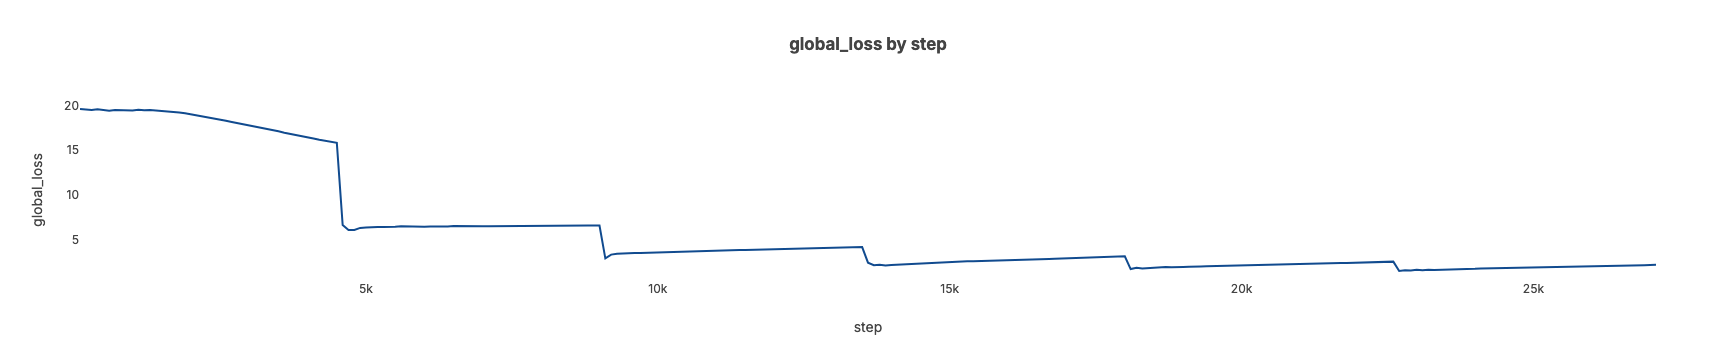

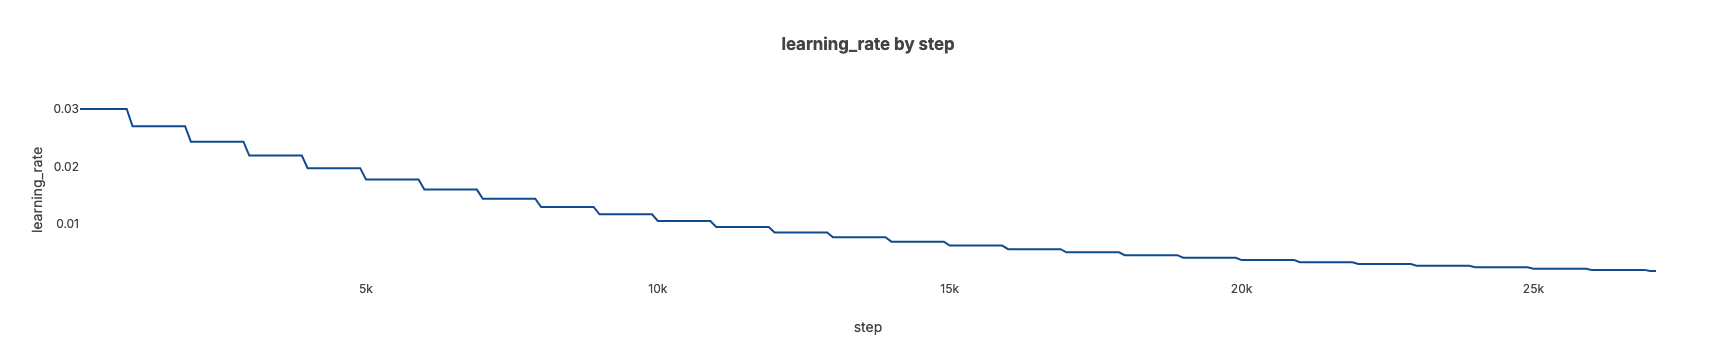

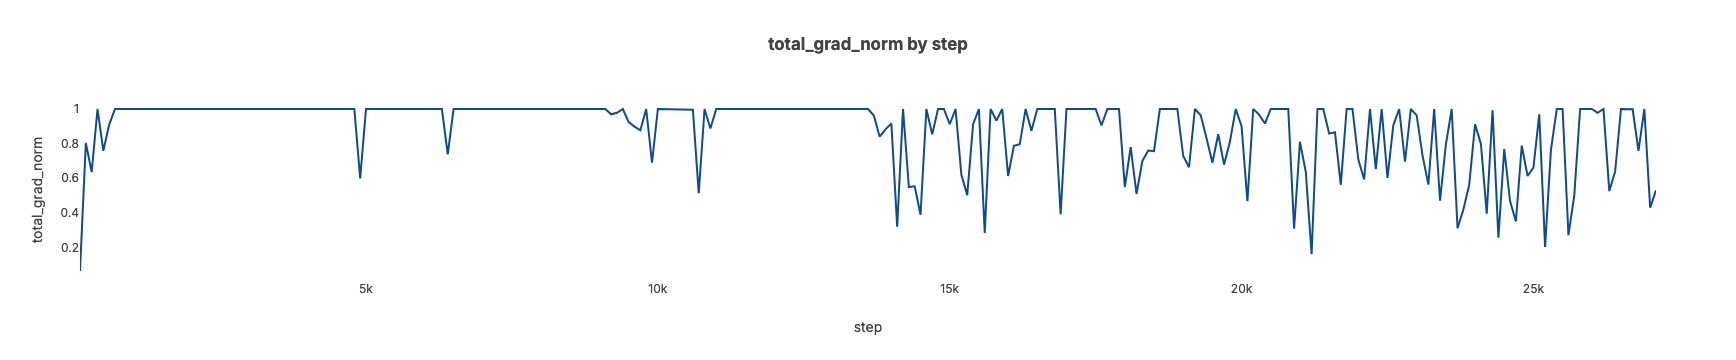

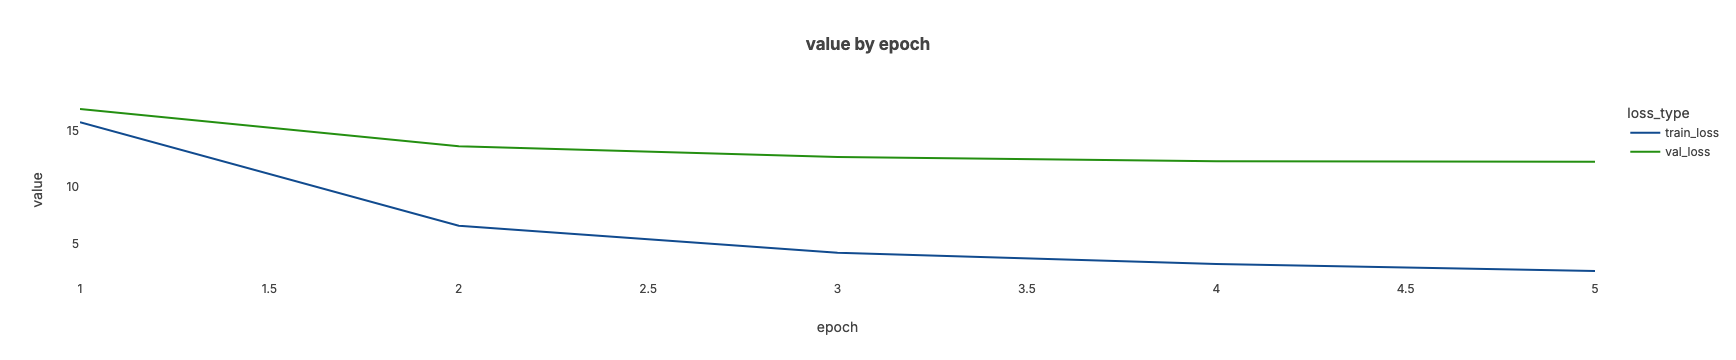

In [39]:
def plot_metric(df, index='step', col: str = None, color=None):
    # Create the plot
    cols = [index, col]
    if color:
        cols.append(color)
    fig = px.line(
        df[cols].dropna(),
        x=index,
        y=col,
        color=color,
        labels={'x': index, 'y': col},
        title=f'{col} by {index}',
    )

    if color:
        fig.update_layout(showlegend=True)

    fig.show()

plot_metric(step_metrics_df, col='global_loss')
plot_metric(step_metrics_df, col='learning_rate')
plot_metric(step_metrics_df, col='total_grad_norm')
plot_metric(epoch_metrics_df, index='epoch', col='value', color='loss_type')

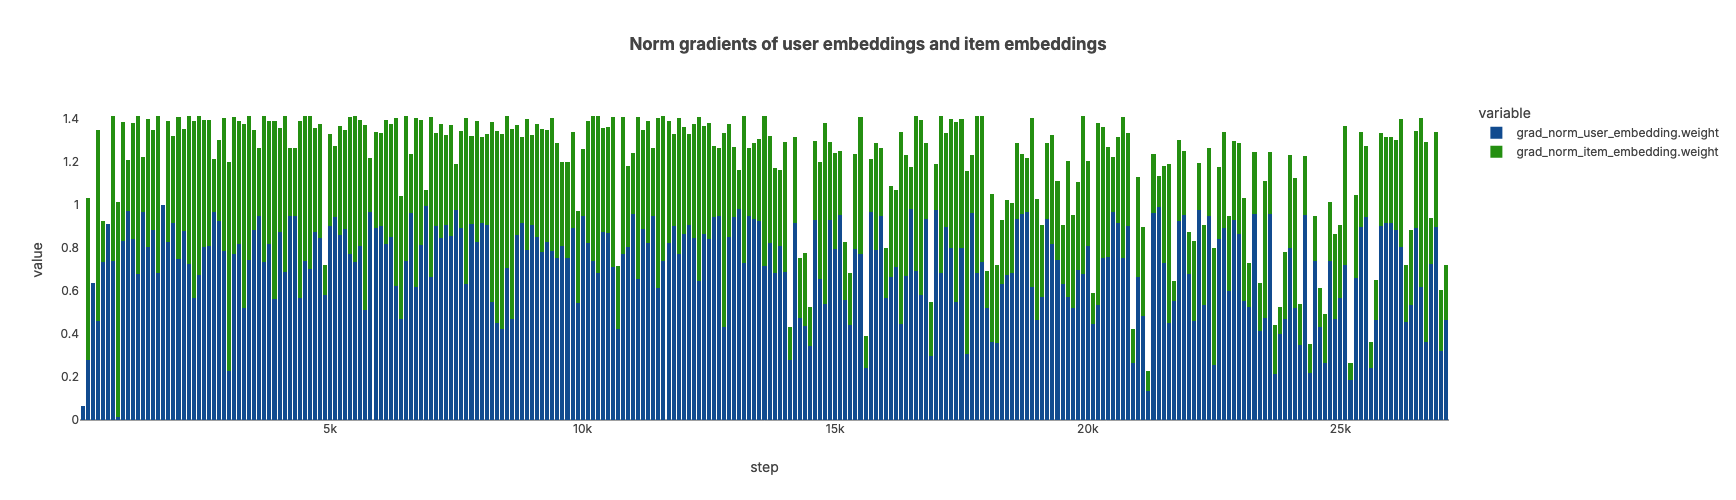

In [36]:
fig = px.bar(
    step_metrics_df,
    x='step',
    y=['grad_norm_user_embedding.weight', 'grad_norm_item_embedding.weight'],
    title='Norm gradients of user embeddings and item embeddings',
    height=500
)
fig.update_layout(showlegend=True, barmode='stack')
fig.show()

# Predict

In [21]:
train_df

,user_id,parent_asin,rating,timestamp
1,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B0863MT183,4.0,1613701986538
2,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B08P8P7686,5.0,1613702112995
3,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B0B7LV3DN2,4.0,1617641445475
4,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B09WMQ6DXG,5.0,1620231368468
70,AHV6QCNBJNSGLATP56JAWJ3C4G2A,B019WRM1IA,5.0,1451860309000
...,...,...,...,...
735704,AHS2PQ33BWQLXC5NNUZS2BFXD34Q,B07TZT67KX,5.0,1622844181866
735800,AFO5SNKILFVJMSJJ2E3BRLDGE4NA,B09T5VN7D1,4.0,1601154352542
735801,AFO5SNKILFVJMSJJ2E3BRLDGE4NA,B09918MSTF,5.0,1602615880364
736772,AEFPHMM7CLX4UJNXJFQF4ZF5GNAA,B07P27XFP7,5.0,1599585146628


In [22]:
user_id = 'AEHW2B54HDLZ3APBEWXHYLZ6SSYQ'
val_df.loc[lambda df: df['user_id'].eq(user_id)]

,user_id,parent_asin,rating,timestamp
34367,AEHW2B54HDLZ3APBEWXHYLZ6SSYQ,B07MYVF61Y,4.0,1654225907045


In [23]:
item_id = 'B07MYVF61Y'
user_indice = idm.get_user_index(user_id)
item_indice = idm.get_item_index(item_id)

model.predict([user_indice], [item_indice])

tensor([4.8345], grad_fn=<SumBackward1>)